In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
from scipy.interpolate import interp1d
import os

ModuleNotFoundError: No module named 'pymaster'

Read high-resolution mask, downgrade it to target resolution, and binarize it

In [2]:
msk_hi = hp.read_map("mask2048_txpipe_gausssim.fits")
nside = 512
npix = hp.nside2npix(nside)
mask = hp.ud_grade(msk_hi, nside_out=nside)
mask[mask > 0.5] = 1
mask[mask <= 0.5] = 0

Read input power spectra and put them in the right shape

In [3]:
ll, cl = np.loadtxt("cls/cosmicshear_cl_s3_s3.txt", unpack=True)
ls = np.arange(3*nside)
cls = interp1d(ll, cl, fill_value=0, bounds_error=False)(ls)

Generate random galaxy positions. We do this only once

In [4]:
def gen_gals(nbar=1.78):
    ngals = int(nbar*4*np.pi*(180*60/np.pi)**2)
    phi = 2*np.pi*np.random.rand(ngals)
    theta = np.arccos(-1+2*np.random.rand(ngals))
    ipix = hp.ang2pix(nside, theta, phi)
    ipix = ipix[mask[ipix] > 0]
    print(len(ipix))
    return ipix

fname_ipix = f'ipix_ns{nside}.npz'
if not os.path.isfile(fname_ipix):
    ipix = gen_gals(nbar=1.78)
    np.savez(fname_ipix, ipix=ipix)
else:
    print("Reading")
    d = np.load(fname_ipix)
    ipix = d['ipix']
wmap = np.bincount(ipix, minlength=npix)
print(np.sum(wmap))
goodpix = wmap > 0

Reading
78996915


Compute workspace (i.e. mode-coupling matrix)

In [5]:
# We use bandpowers of width delta_ell = 10 from ell=2 to ell=3*nside-1
b = nmt.NmtBin(nside, nlb=10)

# This evaluates the MCM
wsp = nmt.NmtWorkspace()
f = nmt.NmtField(wmap, None, spin=2)
wsp.compute_coupling_matrix(f, f, b)
wsp.write_to("wsp.fits")

We do the same again but treating it as a spin-0 field (this will be useful later when computing the covariance)

In [6]:
f = nmt.NmtField(wmap, None, spin=0)
wsp0 = nmt.NmtWorkspace()
wsp0.compute_coupling_matrix(f, f, b)
wsp0.write_to("wsp0.fits")

Now compute the covariance matrix mode-coupling coefficients

In [7]:
# This is the noise variance map. Note that we use simply 0.26^2 as the per-galaxy rms ellipticity.
# In practice you'd compute this from the data (see `gen_cl_from_sim` below).
w2s2 = np.bincount(ipix, minlength=npix, weights=0.26**2*np.ones(len(ipix)))
cwsp = nmt.NmtCovarianceWorkspace()
cwsp.compute_coupling_coefficients(f, f, f, f)

Let's also compute the theoretical power spectrum (accounting for the residual mode-coupling effects), and the power spectrum to be used for covariance calculation. The latter is, as described in Nicola et al. 2020, simply the mode-coupled signal+noise power spectrum divided by the mean of the squared mask.

In [8]:
# Theory power spectrum
cl_theory = wsp.decouple_cell(wsp.couple_cell([cls, 0*cls, 0*cls, 0*cls]))[0]

# Power spectra used in covariances
nl_coupled = np.ones(3*nside) * hp.nside2pixarea(nside) * np.sum(w2s2) / npix
nl_coupled[:2] = 0
nl_coupled = np.array([nl_coupled, 0*nl_coupled, 0*nl_coupled, nl_coupled])
cl_coupled = wsp.couple_cell([cls, 0*cls, 0*cls, 0*cls])
cl_covar = (cl_coupled+nl_coupled)/np.mean(wmap**2)

Now we'll generate 100 Gaussian simulations and compute their power spectra.

In [9]:
def gen_cl_from_sim(sigE=0.26):
    # Generate gamma map
    _, g1, g2 = hp.synfast([0*cls, cls, 0*cls, 0*cls], nside, pol=True, new=True)
    # Sample at galaxy positions and add noise
    e1 = g1[ipix]+np.random.randn(len(ipix))*sigE
    e2 = g2[ipix]+np.random.randn(len(ipix))*sigE
    # Weighted maps and field
    we1 = np.bincount(ipix, minlength=npix, weights=e1)
    we2 = np.bincount(ipix, minlength=npix, weights=e2)
    # Mean ellipticity maps
    m_e1, m_e2 = np.zeros([2, npix])
    m_e1[goodpix] = we1[goodpix]/wmap[goodpix]
    m_e2[goodpix] = we2[goodpix]/wmap[goodpix]
    # Namaster field
    f = nmt.NmtField(wmap, [m_e1, m_e2], n_iter=0)
    # Compute power spectrum
    cl = wsp.decouple_cell(nmt.compute_coupled_cell(f, f))
    # Compute noise bias
    w2s2 = np.bincount(ipix, minlength=npix, weights=0.5*(e1**2+e2**2))
    nl_coupled = np.ones(3*nside) * hp.nside2pixarea(nside) * np.sum(w2s2) / npix
    nl_coupled[:2] = 0
    nl_coupled = np.array([nl_coupled, 0*nl_coupled, 0*nl_coupled, nl_coupled])
    nl = wsp.decouple_cell(nl_coupled)
    return cl, nl

In [10]:
nsims = 100
l_eff = b.get_effective_ells()
cl_all = []
nl_all = []
for i in range(nsims):
    fname = 'cl_sim_%04d.npz' % i
    if os.path.isfile(fname):
        d = np.load(fname)
        cl = d['cl']
        nl = d['nl']
    else:
        print(f"computing {i}")
        cl, nl = gen_cl_from_sim()
        np.savez(fname, cl=cl, nl=nl, ls=l_eff)
    cl_all.append(cl-nl)
    nl_all.append(nl)
cl_all = np.array(cl_all)
nl_all = np.array(nl_all)

Plot resulting power spectra compared with the expected theory prediction

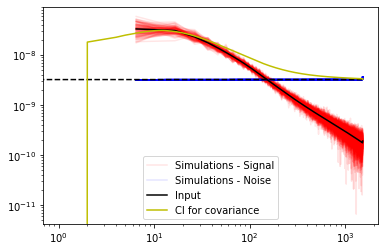

In [11]:
# Plot all sims
plt.plot(l_eff, cl_all[0][0], 'r-', alpha=0.1, label='Simulations - Signal')
plt.plot(l_eff, nl_all[0][0], 'b-', alpha=0.1, label='Simulations - Noise')
for c, n in zip(cl_all, nl_all):
    plt.plot(l_eff, c[0], 'r-', alpha=0.1)
    plt.plot(l_eff, n[0], 'b-', alpha=0.1)
# Plot theory prediction
plt.plot(l_eff, cl_theory, 'k-', label='Input')
# Naive noise bias estimation
plt.plot(ls, np.ones_like(ls)*0.26**2/(1.78*(180*60/np.pi)**2), 'k--')
# C_ell used for covariance
plt.plot(ls, cl_covar[0], 'y-', label='Cl for covariance')
plt.loglog()
plt.legend()

Now compute the theoretical covariance matrix. We compute two versions: one accounting for the spin-2 nature of the cosmic shear field and one that treats it effectively as a scalar field with power spectrum given by the E-mode spectrum. Both will differ only on the very largest scales.

In [12]:
n_bpw = cl_theory.shape[0]
cov_nmt = nmt.gaussian_covariance(cwsp, 2, 2, 2, 2,
                                  cl_covar, cl_covar,
                                  cl_covar, cl_covar,
                                  wsp, wb=wsp).reshape([n_bpw, 4, n_bpw, 4])[:, 0, :, 0]
f = nmt.NmtField(wmap, None, spin=0)
cov_sp0 = nmt.gaussian_covariance(cwsp, 0, 0, 0, 0,
                                  [cl_covar[0]], [cl_covar[0]],
                                  [cl_covar[0]], [cl_covar[0]],
                                  wsp0, wb=wsp0).reshape([n_bpw, 1, n_bpw, 1])[:, 0, :, 0]

Do the same from the simulations

In [13]:
cov_sim = np.cov(np.array(cl_all)[:, 0, :].T)

And compare the results!

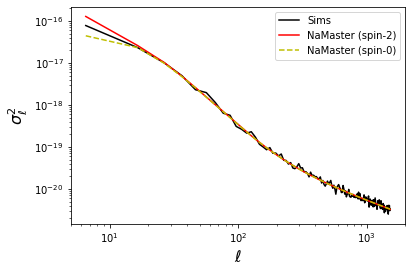

In [14]:
plt.plot(l_eff, np.diag(cov_sim), 'k-', label='Sims')
plt.plot(l_eff, np.diag(cov_nmt), 'r-', label='NaMaster (spin-2)')
plt.plot(l_eff, np.diag(cov_sp0), 'y--', label='NaMaster (spin-0)')
plt.loglog()
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$\sigma^2_\ell$', fontsize=16)
plt.legend()

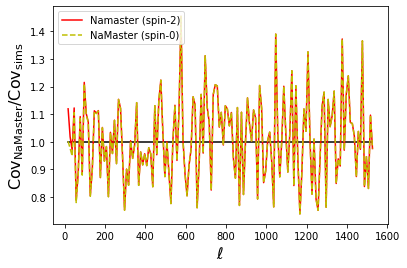

In [17]:
plt.plot(l_eff[1:], np.ones(len(l_eff)-1), 'k-')
plt.plot(l_eff[1:], (np.diag(cov_nmt)/np.diag(cov_sim))[1:], 'r-', label='Namaster (spin-2)')
plt.plot(l_eff[1:], (np.diag(cov_sp0)/np.diag(cov_sim))[1:], 'y--', label='NaMaster (spin-0)')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'${\rm Cov}_{\rm NaMaster}/{\rm Cov}_{\rm sims}$', fontsize=16)
plt.legend()